In [1]:
%matplotlib inline
from helper import *
import plotter as pltr

In [2]:
# Hyper-parameters
window_size = 50
step_size = int(0.1 * window_size)
dataset = 'SMD'

## Step 1. Load Dataset

In [3]:
if dataset == 'SMD':
    GROUP = 1
    ENTITY = 2
    SMD_BASE_PATH = 'Dataset/SMD'

    X_train = load_data('%s/train/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_train.columns = ['m%d' % i for i in range(X_train.shape[1])]
    X_train.index = pd.date_range('2021/03/02', '2021/03/21', periods=X_train.shape[0])
    X_train.index.name = 'timestamp'

    X_test = load_data('%s/test/machine-%d-%d.txt' % (SMD_BASE_PATH, GROUP, ENTITY), header=False)
    X_test.columns = ['m%d' % i for i in range(X_test.shape[1])]
    X_test.index = pd.date_range('2021/03/21', '2021/4/8', periods=X_test.shape[0])
    X_test.index.name = 'timestamp'

    y_true = pd.read_csv('Dataset/SMD/test_label/machine-%d-%d.txt' % (GROUP, ENTITY), header=None)
    y_true.columns = ['label']
    y_true.index = X_test.index

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [5]:
print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (23694, 37)
Test Shape: (23694, 37)


## Step 2. Normalizing Flow

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt
import arviz as az

pm.set_tt_rng(42)
np.random.seed(42)

In [7]:
X_train = X_train[:, [3, 4]]  # select 2 columns

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


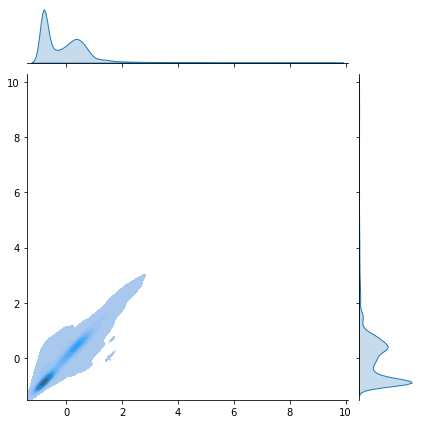

In [8]:
sns.jointplot(X_train[:, 0], X_train[:, 1], kind='kde', fill=True)

![](https://d33wubrfki0l68.cloudfront.net/48eb0ef22c442479b386de3921e68c2647ce5d9d/103a7/2254f6b41ad264ad5f2de5047c66427e/normalizing-flow.svg)

![](images/def3.png)
![defination](./images/def.png)
![](./images/def2.png)

![](./images/def4.png)

In [9]:
X_train.shape

(23694, 37)

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


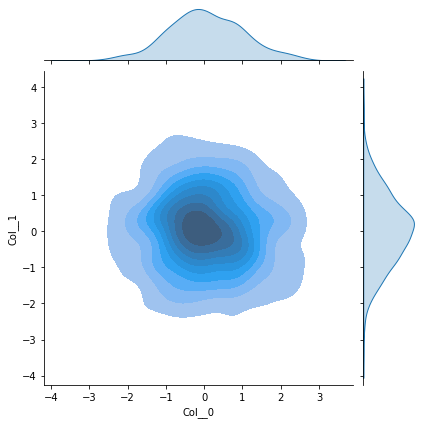

In [10]:
with pm.Model() as model:
    mu = pm.Normal("mu", 0.0, 1)
    sd = pm.Exponential("sd", 1.0)

    pm.Normal('Col', mu=mu, sigma=sd, shape=X_train.shape[1])  # z0
    inference = pm.NFVI(flow='planar*4', jitter=.001, observed=X_train)

## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 1], dftrace.iloc[:, 2], kind='kde', fill=True);

![](./images/def5.png)

![](./images/def5.png)

In [11]:
# inference.approx.params

In [12]:
from collections import OrderedDict, defaultdict
from itertools import count


@theano.configparser.change_flags(compute_test_value="off")
def get_tracker(inference):
    numbers = defaultdict(count)
    params = inference.approx.params
    grads = tt.grad(inference.objective(None), params)
    names = ["%s_%d" % (v.name, next(numbers[v.name])) for v in inference.approx.params]
    return pm.callbacks.Tracker(
        **OrderedDict(
            [(name, v.eval) for name, v in zip(names, params)]
            + [("grad_" + name, v.eval) for name, v in zip(names, grads)]
        )
    )


tracker = get_tracker(inference)

/tmp/ipykernel_306777/3273897301.py:5: DeprecationWarning: Function change_flags is now deprecated! Use theano.config.change_flags instead!
  @theano.configparser.change_flags(compute_test_value="off")


In [13]:
# tracker.whatchdict

In [14]:
approx = inference.fit(
    n=20000,
    score=True,
    obj_optimizer=pm.adagrad_window(learning_rate=0.01),
    obj_n_mc=100,
    callbacks=[pm.callbacks.CheckParametersConvergence(), tracker],
    progressbar=True,
)

Interrupted at 0 [0%]: Average Loss = nan


In [ ]:
traceNF = inference.approx.sample(1000)
dftrace = pm.trace_to_dataframe(traceNF)
# sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1])
sns.jointplot(dftrace.iloc[:, 1], dftrace.iloc[:, 2], kind="kde", fill=True)

In [ ]:
# approximation history(loss)
plt.plot(approx.hist)

In [ ]:
# fmt: off
trackername = ['u_0', 'w_0', 'b_0', 'u_1', 'w_1', 'b_1',
               'grad_u_0', 'grad_w_0', 'grad_b_0', 'grad_u_1', 'grad_w_1', 'grad_b_1']
# fmt: on


def plot_tracker_results(tracker):
    fig, ax = plt.subplots(len(tracker.hist) // 2, 2, figsize=(16, len(tracker.hist) // 2 * 2.3))
    ax = ax.flatten()
    # names = list(tracker.hist.keys())
    names = trackername
    gnames = names[len(names) // 2 :]
    names = names[: len(names) // 2]
    pairnames = zip(names, gnames)

    def plot_params_and_grads(name, gname):
        i = names.index(name)
        left = ax[i * 2]
        right = ax[i * 2 + 1]
        grads = np.asarray(tracker[gname])
        if grads.ndim == 1:
            grads = grads[:, None]
        grads = grads.T
        params = np.asarray(tracker[name])
        if params.ndim == 1:
            params = params[:, None]
        params = params.T
        right.set_title("Gradient of %s" % name)
        left.set_title("Param trace of %s" % name)
        s = params.shape[0]
        for j, (v, g) in enumerate(zip(params, grads)):
            left.plot(v, "-")
            right.plot(g, "o", alpha=1 / s / 10)
        left.legend([name + "_%d" % j for j in range(len(names))])
        right.legend([gname + "_%d" % j for j in range(len(names))])

    for vn, gn in pairnames:
        plot_params_and_grads(vn, gn)
    fig.tight_layout()

In [ ]:
# plot_tracker_results(tracker);

In [ ]:
# az.plot_posterior(traceNF)
# plt.show()

In [ ]:
with model:
    trace_1 = pm.sample(1000, tune=2000, random_seed=42, return_inferencedata=True)
az.plot_trace(trace_1);

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(traceNF, var_names=['Col'], random_seed=42)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))